## 0) Imports & device
This cell imports dependencies and sets CPU/GPU device.


In [1]:

import math
import os
from dataclasses import dataclass
from typing import Dict, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F


# Speed knobs (GPU)
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass

torch.set_default_dtype(torch.float32)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

DEVICE: cuda


## 1) Configuration
All hyperparameters are grouped here for clarity.


In [2]:

@dataclass
class Config:
    # Dimensions
    nx: int = 3
    nth: int = 2
    ny: int = 2
    nz: int = 5  # nx+nth

    # Simulation
    dt: float = 0.1
    T: int = 350
    n_train: int = 256
    n_val: int = 64
    n_test: int = 128

    # Parameter step-change (single jump, then hold)
    jump_frac: float = 0.40
    jump_window: Tuple[int,int] = (60, 140)

    # True noises (for synthetic data)
    Qx_true_diag: Tuple[float,float,float] = (1e-4, 1e-4, 5e-5)
    R_true_diag: Tuple[float,float] = (2e-4, 2e-4)

    # Parameter random-walk base noise (relative to theta_ref)
    qth_base_rel: float = 1e-2

    # Jump detection via NIS (optional)
    jump_M: int = 2
    jump_J: int = 3
    nis_tau: float = 9.21  # chi2(df=2) 99%

    # UT_parameters
    ut_alpha = 1.0
    ut_beta = 0.0
    ut_kappa = 0.0

    # Training
    epochs: int = 300
    batch_size: int = 32
    lr: float = 1e-4
    grad_clip: float = 1.0

    # UKN model
    gru_hidden: int = 32
    freeze_R_during_jump: bool = True

    # Jump logic toggle
    enable_jump_logic_train: bool = True
    enable_jump_logic_eval: bool = True

CFG = Config()
print(CFG)


Config(nx=3, nth=2, ny=2, nz=5, dt=0.1, T=350, n_train=256, n_val=64, n_test=128, jump_frac=0.4, jump_window=(60, 140), Qx_true_diag=(0.0001, 0.0001, 5e-05), R_true_diag=(0.0002, 0.0002), qth_base_rel=0.01, jump_M=2, jump_J=3, nis_tau=9.21, epochs=300, batch_size=32, lr=0.0001, grad_clip=1.0, gru_hidden=32, freeze_R_during_jump=True, enable_jump_logic_train=True, enable_jump_logic_eval=True)


## 2) Synthetic nonlinear system: f(x, θ), h(x)

Example system (replace with your own):
- State: `x=[p, v, b]`
- Parameters: `θ=[k, c]` (enter the **state dynamics**)
- Measurement: `y=[p + 0.1 b, v]`


In [3]:

def f_x_theta(x: torch.Tensor, th: torch.Tensor, dt: float) -> torch.Tensor:
    p, v, b = x[..., 0], x[..., 1], x[..., 2]
    k, c = th[..., 0], th[..., 1]

    p_next = p + dt * v
    v_next = v + dt * (-k * torch.sin(p) - c * v + 0.1 * torch.sin(b))
    b_next = b + dt * (0.05 * torch.cos(p))

    return torch.stack([p_next, v_next, b_next], dim=-1)

def h_x(x: torch.Tensor) -> torch.Tensor:
    p, v, b = x[..., 0], x[..., 1], x[..., 2]
    y1 = p + 0.1 * b
    y2 = v
    return torch.stack([y1, y2], dim=-1)


## 3) EKF Jacobians (augmented z=[x;θ])
EKF baseline needs Jacobians:
- `A = ∂f_aug/∂z` (5×5)
- `H = ∂h/∂z` (2×5)


In [4]:

def jacobian_A_aug(z: torch.Tensor, dt: float) -> torch.Tensor:
    p, v, b = z[..., 0], z[..., 1], z[..., 2]
    k, c = z[..., 3], z[..., 4]

    A = torch.zeros(z.shape[:-1] + (5, 5), device=z.device, dtype=z.dtype)

    # p_next = p + dt v
    A[..., 0, 0] = 1.0
    A[..., 0, 1] = dt

    # v_next = v + dt( -k sin(p) - c v + 0.1 sin(b) )
    A[..., 1, 0] = dt * (-k * torch.cos(p))
    A[..., 1, 1] = 1.0 + dt * (-c)
    A[..., 1, 2] = dt * (0.1 * torch.cos(b))
    A[..., 1, 3] = dt * (-torch.sin(p))
    A[..., 1, 4] = dt * (-v)

    # b_next = b + dt(0.05 cos(p))
    A[..., 2, 0] = dt * (-0.05 * torch.sin(p))
    A[..., 2, 2] = 1.0

    # theta random walk
    A[..., 3, 3] = 1.0
    A[..., 4, 4] = 1.0
    return A

def jacobian_H_aug(device=None, dtype=None) -> torch.Tensor:
    H = torch.zeros((2,5), dtype=dtype or torch.get_default_dtype(), device=device)
    H[0,0] = 1.0
    H[0,2] = 0.1
    H[1,1] = 1.0
    return H


## 4) Data generation (single step-change event in θ)
We simulate sequences where θ jumps once (±20%) at a random time within a window and then stays constant.


In [5]:

def simulate_dataset(cfg: Config, n_seq: int, seed: int = 0) -> Dict[str, np.ndarray]:
    rng = np.random.default_rng(seed)

    T = cfg.T
    dt = cfg.dt

    th_ref = np.array([1.0, 0.2], dtype=np.float64)

    Qx = np.diag(cfg.Qx_true_diag)
    R  = np.diag(cfg.R_true_diag)

    x_all = np.zeros((n_seq, T, cfg.nx), dtype=np.float64)
    th_all = np.zeros((n_seq, T, cfg.nth), dtype=np.float64)
    y_all = np.zeros((n_seq, T, cfg.ny), dtype=np.float64)
    jump_t_all = np.zeros((n_seq,), dtype=np.int64)

    for n in range(n_seq):
        x0 = np.array([0.2, 0.0, 0.1], dtype=np.float64) + rng.normal(0, 0.05, size=(cfg.nx,))
        th0 = th_ref * (1.0 + rng.normal(0, 0.03, size=(cfg.nth,)))

        t_jump = rng.integers(cfg.jump_window[0], cfg.jump_window[1])
        jump_t_all[n] = t_jump

        sign = rng.choice([-1.0, 1.0], size=(cfg.nth,))
        th_jump = th0 * (1.0 + sign * cfg.jump_frac)

        x = x0.copy()
        th = th0.copy()

        for t in range(T):
            if t == t_jump:
                th = th_jump.copy()

            x_t = torch.tensor(x, dtype=torch.float64)
            th_t = torch.tensor(th, dtype=torch.float64)
            x_next = f_x_theta(x_t, th_t, dt).cpu().numpy()
            x_next = x_next + rng.multivariate_normal(torch.zeros(cfg.nx), Qx)

            y = h_x(torch.tensor(x_next, dtype=torch.float64)).cpu().numpy()
            y = y + rng.multivariate_normal(torch.zeros(cfg.ny), R)

            x_all[n, t] = x_next
            th_all[n, t] = th
            y_all[n, t] = y

            x = x_next

    return {"x_true": x_all, "th_true": th_all, "y_meas": y_all, "jump_t": jump_t_all, "th_ref": th_ref}

train_data = simulate_dataset(CFG, CFG.n_train, seed=1)
val_data   = simulate_dataset(CFG, CFG.n_val, seed=2)
test_data  = simulate_dataset(CFG, CFG.n_test, seed=3)

print("train shapes:", train_data["x_true"].shape, train_data["y_meas"].shape)



SAVE_DIR = os.path.join(os.getcwd(), "data_cache")
os.makedirs(SAVE_DIR, exist_ok=True)

train_path = os.path.join(SAVE_DIR, "train_data.npz")
val_path   = os.path.join(SAVE_DIR, "val_data.npz")
test_path  = os.path.join(SAVE_DIR, "test_data.npz")

def save_dataset_npz(path, data_dict):
    # Ensure safe dtypes
    np.savez_compressed(
        path,
        x_true=data_dict["x_true"].astype(np.float64),
        th_true=data_dict["th_true"].astype(np.float64),
        y_meas=data_dict["y_meas"].astype(np.float64),
        jump_t=data_dict["jump_t"].astype(np.int64),
        th_ref=data_dict["th_ref"].astype(np.float64),
    )

save_dataset_npz(train_path, train_data)
save_dataset_npz(val_path,   val_data)
save_dataset_npz(test_path,  test_data)

print("Saved:")
print(" -", train_path)
print(" -", val_path)
print(" -", test_path)


# train_data = dict(np.load(train_path, allow_pickle=True))
# val_data   = dict(np.load(val_path, allow_pickle=True))
# test_data  = dict(np.load(test_path, allow_pickle=True))
# print(train_data["x_true"].shape, train_data["y_meas"].shape)


C:\Users\minhy\AppData\Local\Temp\ipykernel_13660\3576585461.py:37: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x_next = x_next + rng.multivariate_normal(torch.zeros(cfg.nx), Qx)
C:\Users\minhy\AppData\Local\Temp\ipykernel_13660\3576585461.py:40: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y = y + rng.multivariate_normal(torch.zeros(cfg.ny), R)


train shapes: (256, 350, 3) (256, 350, 2)
Saved:
 - c:\Users\minhy\Documents\Research\Unscented-KalmanNet\data_cache\train_data.npz
 - c:\Users\minhy\Documents\Research\Unscented-KalmanNet\data_cache\val_data.npz
 - c:\Users\minhy\Documents\Research\Unscented-KalmanNet\data_cache\test_data.npz


In [6]:
# --- GPU optimization: move datasets to torch tensors ONCE (avoid CPU->GPU copy every mini-batch) ---
DTYPE = torch.get_default_dtype()

def pack_z_np(data_dict):
    return np.concatenate([data_dict["x_true"], data_dict["th_true"]], axis=-1)

y_train_all = torch.from_numpy(train_data["y_meas"]).to(DEVICE, dtype=DTYPE)
z_train_all = torch.from_numpy(pack_z_np(train_data)).to(DEVICE, dtype=DTYPE)

y_val_all = torch.from_numpy(val_data["y_meas"]).to(DEVICE, dtype=DTYPE)
z_val_all = torch.from_numpy(pack_z_np(val_data)).to(DEVICE, dtype=DTYPE)

y_test_all = torch.from_numpy(test_data["y_meas"]).to(DEVICE, dtype=DTYPE)
z_test_all = torch.from_numpy(pack_z_np(test_data)).to(DEVICE, dtype=DTYPE)

print("Moved datasets to device:", DEVICE, "dtype:", DTYPE)

Moved datasets to device: cuda dtype: torch.float32


## 5) Robust UT helpers + SPD utilities

This section includes:
- Robust Cholesky with automatic jitter escalation.
- Sigma point generation.
- UT mean/cov and cross-cov.
- SPD construction from diagonal parameters.


In [7]:

def symmetrize(P: torch.Tensor) -> torch.Tensor:
    return 0.5 * (P + P.transpose(-1, -2))

def chol_psd(P: torch.Tensor, jitter: float = 1e-6, max_tries: int = 8) -> torch.Tensor:
    P = symmetrize(P)
    I = torch.eye(P.shape[-1], device=P.device, dtype=P.dtype)
    jit = jitter
    for _ in range(max_tries):
        try:
            return torch.linalg.cholesky(P + jit * I)
        except Exception:
            jit *= 10.0
    w, V = torch.linalg.eigh(P)
    w = torch.clamp(w, min=jitter)
    P_fix = V @ torch.diag_embed(w) @ V.transpose(-1, -2)
    return torch.linalg.cholesky(P_fix + jitter * I)

def inv_via_cholesky(S: torch.Tensor) -> torch.Tensor:
    L = chol_psd(S)
    I = torch.eye(S.shape[-1], device=S.device, dtype=S.dtype).expand(S.shape[0], -1, -1)
    return torch.cholesky_solve(I, L)

def spd_from_diag(raw: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    s = torch.nn.functional.softplus(raw) + eps
    return torch.diag_embed(s**2)

def sigma_points(mean: torch.Tensor, cov: torch.Tensor, gamma: float) -> torch.Tensor:
    if mean.dim() == 1:
        mean = mean.unsqueeze(0)
        cov = cov.unsqueeze(0)
        squeeze = True
    else:
        squeeze = False
    B, n = mean.shape
    S = gamma * chol_psd(cov)
    Xi0 = mean.unsqueeze(1)
    cols = S.transpose(-1, -2)
    Xi = torch.cat([Xi0, Xi0 + cols, Xi0 - cols], dim=1)
    return Xi.squeeze(0) if squeeze else Xi

def ut_weights(n: int, alpha: float = 1e-3, beta: float = 2.0, kappa: float = 0.0):
    lam = alpha**2 * (n + kappa) - n
    c = n + lam
    Wm = torch.full((2*n+1,), 0.5/c, dtype=torch.get_default_dtype(), device=DEVICE)
    Wc = torch.full((2*n+1,), 0.5/c, dtype=torch.get_default_dtype(), device=DEVICE)
    Wm[0] = lam / c
    Wc[0] = lam / c + (1 - alpha**2 + beta)
    gamma = math.sqrt(c)
    return Wm, Wc, gamma

def ut_mean_cov(Xi: torch.Tensor, Wm: torch.Tensor, Wc: torch.Tensor):
    mean = (Xi * Wm.view(1, -1, 1)).sum(dim=1)
    d = Xi - mean.unsqueeze(1)
    cov = torch.einsum("bln,blm,l->bnm", d, d, Wc)
    return mean, symmetrize(cov)

def ut_cross_cov(Xi: torch.Tensor, Yi: torch.Tensor, x_mean: torch.Tensor, y_mean: torch.Tensor, Wc: torch.Tensor):
    dx = Xi - x_mean.unsqueeze(1)
    dy = Yi - y_mean.unsqueeze(1)
    return torch.einsum("bln,blm,l->bnm", dx, dy, Wc)


## 6) EKF-aug baseline
EKF uses Jacobians to propagate covariance.


In [8]:

@torch.no_grad()
def ekf_aug_run(cfg: Config, y: torch.Tensor, z0: torch.Tensor, P0: torch.Tensor,
                Qx: torch.Tensor, R: torch.Tensor, th_ref: torch.Tensor,
                enable_jump_logic: bool = True):
    B, T, _ = y.shape
    H = jacobian_H_aug(device=y.device, dtype=y.dtype)

    QxB = Qx.unsqueeze(0).expand(B, -1, -1) if Qx.dim() == 2 else Qx
    RB  = R.unsqueeze(0).expand(B, -1, -1)  if R.dim() == 2 else R

    z, P = z0, P0
    z_out, P_out = [], []

    consec = torch.zeros((B,), device=y.device, dtype=torch.int64)
    jump_count = torch.zeros((B,), device=y.device, dtype=torch.int64)

    sigma_base = cfg.qth_base_rel * th_ref.abs()
    Qth_base = torch.diag_embed(sigma_base**2).unsqueeze(0).expand(B, -1, -1)
    sigma_jump = (cfg.jump_frac / math.sqrt(cfg.jump_J)) * th_ref.abs()
    Qth_jump = torch.diag_embed(sigma_jump**2).unsqueeze(0).expand(B, -1, -1)

    I5 = torch.eye(cfg.nz, device=y.device, dtype=y.dtype).unsqueeze(0).expand(B, -1, -1)
    I2 = torch.eye(cfg.ny, device=y.device, dtype=y.dtype).unsqueeze(0).expand(B, -1, -1)

    for t in range(T):
        x = z[:, :3]
        th = z[:, 3:]
        x_pred = f_x_theta(x, th, cfg.dt)
        z_pred = torch.cat([x_pred, th], dim=-1)

        A = jacobian_A_aug(z, cfg.dt)

        Qth = Qth_base
        if enable_jump_logic:
            Qth = torch.where(jump_count.view(B,1,1) > 0, Qth_jump, Qth_base)

        Q_aug = torch.zeros((B,5,5), device=y.device, dtype=y.dtype)
        Q_aug[:, :3, :3] = QxB
        Q_aug[:, 3:, 3:] = Qth

        P_pred = A @ P @ A.transpose(-1,-2) + Q_aug
        P_pred = symmetrize(P_pred) + 1e-9 * I5

        y_pred = h_x(x_pred)
        e = y[:, t] - y_pred

        S = symmetrize(H @ P_pred @ H.transpose(-1,-2) + RB) + 1e-9 * I2
        Sinv = inv_via_cholesky(S)

        K = P_pred @ H.transpose(-1,-2) @ Sinv
        z = z_pred + torch.einsum("bmn,bn->bm", K, e)

        KH = K @ H
        P = (I5 - KH) @ P_pred @ (I5 - KH).transpose(-1,-2) + K @ RB @ K.transpose(-1,-2)
        P = symmetrize(P) + 1e-9 * I5

        if enable_jump_logic:
            nis = torch.einsum("bi,bij,bj->b", e, Sinv, e)
            exceed = nis > cfg.nis_tau
            consec = torch.where(exceed, consec + 1, torch.zeros_like(consec))
            trigger = consec >= cfg.jump_M
            jump_count = torch.where(trigger, torch.full_like(jump_count, cfg.jump_J), jump_count)
            consec = torch.where(trigger, torch.zeros_like(consec), consec)
            jump_count = torch.clamp(jump_count - 1, min=0)

        z_out.append(z); P_out.append(P)

    return torch.stack(z_out, dim=1), torch.stack(P_out, dim=1)


## 7) UKF-aug baseline
Uses the standard UKF covariance update: `P = P_pred - K S K^T`.


In [9]:

@torch.no_grad()
def ukf_aug_run(cfg: Config, y: torch.Tensor, z0: torch.Tensor, P0: torch.Tensor,
                Qx: torch.Tensor, R: torch.Tensor, th_ref: torch.Tensor,
                enable_jump_logic: bool = True,
                ut_alpha: float = 1e-3, ut_beta: float = 2.0, ut_kappa: float = 0.0):
    B, T, _ = y.shape
    n = cfg.nz
    Wm, Wc, gamma = ut_weights(n, alpha=ut_alpha, beta=ut_beta, kappa=ut_kappa)
    Wm, Wc = Wm.to(y.device), Wc.to(y.device)

    QxB = Qx.unsqueeze(0).expand(B, -1, -1) if Qx.dim() == 2 else Qx
    RB  = R.unsqueeze(0).expand(B, -1, -1)  if R.dim() == 2 else R

    z, P = z0, P0
    z_out, P_out = [], []

    consec = torch.zeros((B,), device=y.device, dtype=torch.int64)
    jump_count = torch.zeros((B,), device=y.device, dtype=torch.int64)

    sigma_base = cfg.qth_base_rel * th_ref.abs()
    Qth_base = torch.diag_embed(sigma_base**2).unsqueeze(0).expand(B, -1, -1)
    sigma_jump = (cfg.jump_frac / math.sqrt(cfg.jump_J)) * th_ref.abs()
    Qth_jump = torch.diag_embed(sigma_jump**2).unsqueeze(0).expand(B, -1, -1)

    I5 = torch.eye(cfg.nz, device=y.device, dtype=y.dtype).unsqueeze(0).expand(B, -1, -1)
    I2 = torch.eye(cfg.ny, device=y.device, dtype=y.dtype).unsqueeze(0).expand(B, -1, -1)

    for t in range(T):
        Xi = sigma_points(z, P, gamma)
        Xi_x, Xi_th = Xi[..., :3], Xi[..., 3:]
        X_pred = f_x_theta(Xi_x, Xi_th, cfg.dt)
        Zi_pred = torch.cat([X_pred, Xi_th], dim=-1)

        z_pred, P_pred_noQ = ut_mean_cov(Zi_pred, Wm, Wc)

        Qth = Qth_base
        if enable_jump_logic:
            Qth = torch.where(jump_count.view(B,1,1) > 0, Qth_jump, Qth_base)

        Q_aug = torch.zeros((B,5,5), device=y.device, dtype=y.dtype)
        Q_aug[:, :3, :3] = QxB
        Q_aug[:, 3:, 3:] = Qth

        P_pred = symmetrize(P_pred_noQ + Q_aug) + 1e-9 * I5

        Yi = h_x(Zi_pred[..., :3])
        y_pred, S_noR = ut_mean_cov(Yi, Wm, Wc)
        Pzy = ut_cross_cov(Zi_pred, Yi, z_pred, y_pred, Wc)

        S = symmetrize(S_noR + RB) + 1e-9 * I2
        Sinv = inv_via_cholesky(S)
        K = torch.einsum("bmn,bnk->bmk", Pzy, Sinv)

        e = y[:, t] - y_pred
        z = z_pred + torch.einsum("bmn,bn->bm", K, e)

        P = symmetrize(P_pred - K @ S @ K.transpose(-1, -2)) + 1e-9 * I5

        if enable_jump_logic:
            nis = torch.einsum("bi,bij,bj->b", e, Sinv, e)
            exceed = nis > cfg.nis_tau
            consec = torch.where(exceed, consec + 1, torch.zeros_like(consec))
            trigger = consec >= cfg.jump_M
            jump_count = torch.where(trigger, torch.full_like(jump_count, cfg.jump_J), jump_count)
            consec = torch.where(trigger, torch.zeros_like(consec), consec)
            jump_count = torch.clamp(jump_count - 1, min=0)

        z_out.append(z); P_out.append(P)

    return torch.stack(z_out, dim=1), torch.stack(P_out, dim=1)


## 8) UKN v2 model: UKF backbone + (Enc→GRU→Dec) + time-varying Qx (diag) + full Rt via Cholesky

In [10]:
# UKN v2 (full R via Cholesky) + time-varying Qx (full via Cholesky)
# - Richer features (innovation, whitened innovation, trends, covariance scales, ||K||, dθ)
# - Encoder/Decoder around GRU
# - R_k is full SPD from Cholesky L_k (diag via softplus; off-diag unconstrained)
# - Qx_k is full SPD from Cholesky Lq_k (diag via softplus; off-diag unconstrained)

import math

def _chol_solve_vec(L: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    # Solve (L L^T) x = b
    y = torch.linalg.solve_triangular(L, b.unsqueeze(-1), upper=False).squeeze(-1)
    x = torch.linalg.solve_triangular(L.transpose(-1, -2), y.unsqueeze(-1), upper=True).squeeze(-1)
    return x

def _build_chol_L(log_diag: torch.Tensor, off: torch.Tensor, ny: int, eps: float = 1e-6) -> torch.Tensor:
    '''
    log_diag: (B, ny) -> diag(L) = softplus(log_diag)+eps
    off: (B, ny*(ny-1)/2) fills strictly lower triangle
    '''
    B = log_diag.shape[0]
    L = torch.zeros((B, ny, ny), device=log_diag.device, dtype=log_diag.dtype)
    diag = eps + F.softplus(log_diag)
    L[:, torch.arange(ny, device=log_diag.device), torch.arange(ny, device=log_diag.device)] = diag

    idx = torch.tril_indices(ny, ny, offset=-1, device=log_diag.device)
    L[:, idx[0], idx[1]] = off
    return L

def _spd_from_chol(L: torch.Tensor, jitter: float = 1e-9) -> torch.Tensor:
    B, ny, _ = L.shape
    I = torch.eye(ny, device=L.device, dtype=L.dtype).unsqueeze(0).expand(B, -1, -1)
    R = L @ L.transpose(-1, -2)
    return 0.5 * (R + R.transpose(-1, -2)) + jitter * I

def _diag_spd_from_logdiag(logd: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    d = eps + F.softplus(logd)
    return torch.diag_embed(d)

def gaussian_nll_state_only(x_true: torch.Tensor, x_hat: torch.Tensor, Px: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    '''
    x_true, x_hat: (B, T, nx)
    Px: (B, T, nx, nx)
    returns: scalar mean NLL
    '''
    B, T, nx = x_true.shape
    I = torch.eye(nx, device=Px.device, dtype=Px.dtype).view(1, 1, nx, nx)
    Px = 0.5 * (Px + Px.transpose(-1, -2)) + eps * I

    L = torch.linalg.cholesky(Px)            # (B,T,nx,nx)
    e = (x_true - x_hat)                    # (B,T,nx)

    e2 = e.reshape(B * T, nx)
    L2 = L.reshape(B * T, nx, nx)
    sol = _chol_solve_vec(L2, e2)           # (B*T,nx)
    maha = torch.sum(e2 * sol, dim=-1)      # (B*T,)
    logdet = 2.0 * torch.sum(torch.log(torch.diagonal(L2, dim1=-2, dim2=-1) + 1e-12), dim=-1)
    nll = 0.5 * (maha + logdet + nx * math.log(2.0 * math.pi))
    return nll.mean()

import math
import torch

def measurement_nll(e: torch.Tensor, S: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """
    e: (B, T, ny)
    S: (B, T, ny, ny)
    """
    B, T, ny = e.shape
    I = torch.eye(ny, device=S.device, dtype=S.dtype).view(1,1,ny,ny)
    S = 0.5*(S + S.transpose(-1, -2)) + eps*I

    S2 = S.reshape(B*T, ny, ny)
    e2 = e.reshape(B*T, ny)

    L = torch.linalg.cholesky(S2)

    y = torch.linalg.solve_triangular(L, e2.unsqueeze(-1), upper=False).squeeze(-1)
    x = torch.linalg.solve_triangular(L.transpose(-1,-2), y.unsqueeze(-1), upper=True).squeeze(-1)
    maha = torch.sum(e2 * x, dim=-1)

    logdet = 2.0 * torch.sum(torch.log(torch.diagonal(L, dim1=-2, dim2=-1) + 1e-12), dim=-1)

    nll = 0.5 * (maha + logdet + ny * math.log(2.0 * math.pi))
    return nll.mean()


class UKN(nn.Module):
    '''
    UKN v2:
      - UKF backbone on augmented state z=[x;θ]
      - Neural module outputs time-varying full R_k via Cholesky and time-varying diagonal Qx_k
      - Keeps existing jump logic for θ-noise (Qθ_base/Qθ_jump)
    '''
    def __init__(self, cfg: Config, th_ref: np.ndarray):
        super().__init__()
        self.cfg = cfg
        self.ny, self.nx, self.nz, self.nth = cfg.ny, cfg.nx, cfg.nz, cfg.nth
        self.noff = self.ny * (self.ny - 1) // 2

        self.noffx = self.nx * (self.nx - 1) // 2
        # Recurrent initial states for noise params (learned)
        self.logRdiag0 = nn.Parameter(torch.zeros(self.ny, dtype=torch.get_default_dtype()))
        self.Roff0     = nn.Parameter(torch.zeros(self.noff, dtype=torch.get_default_dtype()))
        self.logQxdiag0 = nn.Parameter(torch.zeros(self.nx, dtype=torch.get_default_dtype()))
        self.Qxoff0     = nn.Parameter(torch.zeros(self.noffx, dtype=torch.get_default_dtype()))

        # Feature dimension
        self.feat_dim = 4*self.ny + self.nx + self.ny + 3 + self.nth

        enc_dim = getattr(cfg, "enc_dim", 64)
        hid     = getattr(cfg, "gru_hidden", 64)
        dec_dim = getattr(cfg, "dec_dim", 64)

        self.enc = nn.Sequential(
            nn.LayerNorm(self.feat_dim),
            nn.Linear(self.feat_dim, enc_dim),
            nn.SiLU(),
            nn.Linear(enc_dim, enc_dim),
            nn.SiLU(),
        )
        self.gru = nn.GRU(input_size=enc_dim, hidden_size=hid, batch_first=True)
        self.dec = nn.Sequential(
            nn.Linear(hid, dec_dim),
            nn.SiLU(),
            nn.Linear(dec_dim, dec_dim),
            nn.SiLU(),
        )
        self.head_dlogRdiag = nn.Linear(dec_dim, self.ny)
        self.head_dRoff     = nn.Linear(dec_dim, self.noff)
        self.head_dlogQxdiag = nn.Linear(dec_dim, self.nx)
        self.head_dQxoff     = nn.Linear(dec_dim, self.noffx)

        # UT weights
        Wm, Wc, gamma = ut_weights(cfg.nz, alpha=cfg.ut_alpha, beta=cfg.ut_beta, kappa=cfg.ut_kappa)
        self.register_buffer("Wm", Wm)
        self.register_buffer("Wc", Wc)
        self.gamma = gamma

        th_ref_t = torch.tensor(th_ref, device=DEVICE, dtype=torch.get_default_dtype())
        self.register_buffer("th_ref", th_ref_t)

    def _theta_Q_base_jump(self, B: int, device):
        cfg = self.cfg
        sigma_base = cfg.qth_base_rel * self.th_ref.abs()
        Qth_base = torch.diag_embed(sigma_base**2).to(device).unsqueeze(0).expand(B, -1, -1)

        sigma_jump = (cfg.jump_frac / math.sqrt(cfg.jump_J)) * self.th_ref.abs()
        Qth_jump = torch.diag_embed(sigma_jump**2).to(device).unsqueeze(0).expand(B, -1, -1)
        return Qth_base, Qth_jump

    def forward(self, y: torch.Tensor, z0: torch.Tensor, P0: torch.Tensor, enable_jump_logic: bool = True):
        
        cfg = self.cfg
        device = y.device
        B, T, _ = y.shape
        ny, nx, nz = self.ny, self.nx, self.nz
        Wm, Wc, gamma = self.Wm.to(device), self.Wc.to(device), self.gamma

        Qth_base, Qth_jump = self._theta_Q_base_jump(B, device)

        z = z0
        P = P0

        # Recurrent noise states
        logRdiag = self.logRdiag0.to(device).unsqueeze(0).expand(B, -1)  # (B,ny)
        Roff     = self.Roff0.to(device).unsqueeze(0).expand(B, -1)      # (B,noff)
        logQxdiag = self.logQxdiag0.to(device).unsqueeze(0).expand(B, -1)  # (B,nx)
        Qxoff     = self.Qxoff0.to(device).unsqueeze(0).expand(B, -1)      # (B,noffx)

        # GRU hidden state
        h = torch.zeros((1, B, cfg.gru_hidden), device=device, dtype=y.dtype)

        # Jump logic state
        consec = torch.zeros((B,), device=device, dtype=torch.int64)
        jump_count = torch.zeros((B,), device=device, dtype=torch.int64)

        # Previous innovation / filtered z / K-norm
        e_prev = torch.zeros((B, ny), device=device, dtype=y.dtype)
        z_prev_filt = z0
        Knorm_prev = torch.zeros((B, 1), device=device, dtype=y.dtype)

        # Logs
        z_list, P_list = [], []
        logRdiag_list, Roff_list, logQxdiag_list, Qxoff_list = [], [], [], []
        nis_list, jc_list = [], []
        e_list, S_list = [], []   # NEW: innovation and innovation covariance for measurement NLL


        Inz = torch.eye(nz, device=device, dtype=y.dtype).unsqueeze(0).expand(B, -1, -1)
        Iny = torch.eye(ny, device=device, dtype=y.dtype).unsqueeze(0).expand(B, -1, -1)
        Inx = torch.eye(nx, device=device, dtype=y.dtype).unsqueeze(0).expand(B, -1, -1)

        for t in range(T):
            # ---- Time update (UKF) ----
            Xi = sigma_points(z, P, gamma)                       # (B,2nz+1,nz)
            Xi_x, Xi_th = Xi[..., :nx], Xi[..., nx:]
            X_pred = f_x_theta(Xi_x, Xi_th, cfg.dt)
            Zi_pred = torch.cat([X_pred, Xi_th], dim=-1)          # (B,2nz+1,nz)

            z_pred, P_pred_noQ = ut_mean_cov(Zi_pred, Wm, Wc)     # (B,nz), (B,nz,nz)

            # θ noise (rule-based)
            Qth = Qth_base
            if enable_jump_logic:
                Qth = torch.where(jump_count.view(B, 1, 1) > 0, Qth_jump, Qth_base)

            # ---- Measurement prediction without R ----
            Yi = h_x(Zi_pred[..., :nx])                           # (B,2nz+1,ny)
            y_pred, S0 = ut_mean_cov(Yi, Wm, Wc)                  # (B,ny), (B,ny,ny)
            Pzy = ut_cross_cov(Zi_pred, Yi, z_pred, y_pred, Wc)   # (B,nz,ny)

            # ---- Features ----
            e = y[:, t] - y_pred                                  # (B,ny)
            de = e - e_prev
            e_prev = e

            S0 = symmetrize(S0) + 1e-9 * Iny
            Ls0 = torch.linalg.cholesky(S0)
            w_e = _chol_solve_vec(Ls0, e)                          # S0^{-1} e
            nis0 = torch.sum(e * w_e, dim=-1)                      # e^T S0^{-1} e
            logdetS0 = 2.0 * torch.sum(torch.log(torch.diagonal(Ls0, dim1=-2, dim2=-1) + 1e-12), dim=-1)

            dtheta_pred = z_pred[:, nx:] - z_prev_filt[:, nx:]     # (B,nth)

            diagP_pred_x = torch.diagonal(P_pred_noQ[:, :nx, :nx] + 1e-9 * Inx, dim1=-2, dim2=-1)
            diagS0 = torch.diagonal(S0, dim1=-2, dim2=-1)

            feat = torch.cat([
                e, de, w_e, e.abs(),
                torch.log(diagP_pred_x + 1e-12),
                torch.log(diagS0 + 1e-12),
                nis0.unsqueeze(-1),
                logdetS0.unsqueeze(-1),
                Knorm_prev,
                dtheta_pred
            ], dim=-1)

            # ---- Enc→GRU→Dec ----
            enc = self.enc(feat).unsqueeze(1)                      # (B,1,enc_dim)
            out, h = self.gru(enc, h)                              # (B,1,hid)
            dec = self.dec(out.squeeze(1))                         # (B,dec_dim)

            dlogRdiag = self.head_dlogRdiag(dec)
            dRoff     = self.head_dRoff(dec)
            dlogQxdiag = self.head_dlogQxdiag(dec)
            dQxoff     = self.head_dQxoff(dec)

            # Optional: freeze R during jump window
            if getattr(cfg, "freeze_R_during_jump", False) and enable_jump_logic:
                mask = (jump_count > 0).unsqueeze(-1)
                dlogRdiag = torch.where(mask, torch.zeros_like(dlogRdiag), dlogRdiag)
                dRoff     = torch.where(mask, torch.zeros_like(dRoff), dRoff)

            # Recurrent updates
            logRdiag = logRdiag + dlogRdiag
            Roff     = Roff + dRoff
            logQxdiag = logQxdiag + dlogQxdiag
            Qxoff     = Qxoff + dQxoff
            # Clipping (stability)
            logRdiag = torch.clamp(logRdiag, -20.0, 20.0)
            logQxdiag = torch.clamp(logQxdiag, -25.0, 10.0)
            Qxoff     = torch.clamp(Qxoff, -5.0, 5.0)
            Roff     = torch.clamp(Roff, -5.0, 5.0)

            # Build R_k (full) and Qx_k (diag)
            Lr = _build_chol_L(logRdiag, Roff, ny, eps=1e-6)
            Rk = _spd_from_chol(Lr, jitter=1e-9)
            Lq = _build_chol_L(logQxdiag, Qxoff, nx, eps=1e-8)
            Qxk = _spd_from_chol(Lq, jitter=1e-9)

            # Finalize P_pred with Qx + Qθ
            Q_aug = torch.zeros((B, nz, nz), device=device, dtype=y.dtype)
            Q_aug[:, :nx, :nx] = Qxk
            Q_aug[:, nx:, nx:] = Qth
            P_pred = symmetrize(P_pred_noQ + Q_aug) + 1e-9 * Inz

            # ---- Measurement update ----
            S = symmetrize(S0 + Rk) + 1e-9 * Iny

            e_list.append(e)
            S_list.append(S)

            Sinv = inv_via_cholesky(S)

            K = Pzy @ Sinv                                           # (B,nz,ny)
            Knorm_prev = torch.norm(K.reshape(B, -1), dim=-1, p=2).unsqueeze(-1).detach()

            z = z_pred + torch.einsum("bmn,bn->bm", K, e)
            P = symmetrize(P_pred - K @ S @ K.transpose(-1, -2)) + 1e-9 * Inz

            nis = torch.einsum("bi,bij,bj->b", e, Sinv, e)

            # Jump logic
            if enable_jump_logic:
                exceed = nis > cfg.nis_tau
                consec = torch.where(exceed, consec + 1, torch.zeros_like(consec))
                trigger = consec >= cfg.jump_M
                jump_count = torch.where(trigger, torch.full_like(jump_count, cfg.jump_J), jump_count)
                consec = torch.where(trigger, torch.zeros_like(consec), consec)
                jump_count = torch.clamp(jump_count - 1, min=0)

            z_prev_filt = z

            # logs
            z_list.append(z); P_list.append(P)
            logRdiag_list.append(logRdiag); Roff_list.append(Roff); logQxdiag_list.append(logQxdiag)
            Qxoff_list.append(Qxoff)
            nis_list.append(nis); jc_list.append(jump_count)

        return {
            "z_filt": torch.stack(z_list, dim=1),
            "P_filt": torch.stack(P_list, dim=1),
            "logRdiag": torch.stack(logRdiag_list, dim=1),
            "Roff": torch.stack(Roff_list, dim=1),
            "logQxdiag": torch.stack(logQxdiag_list, dim=1),
            "Qxoff": torch.stack(Qxoff_list, dim=1),
            "nis": torch.stack(nis_list, dim=1),
            "jump_count": torch.stack(jc_list, dim=1),
            "innov": torch.stack(e_list, dim=1),   # (B,T,ny)
            "S":     torch.stack(S_list, dim=1),   # (B,T,ny,ny)
        }

## 9) Loss functions (v2): state-only MSE + state-only Gaussian NLL + regularizers

Training uses **state-only supervision** (no parameter ground truth required):
- MSE on filtered state `x` (not augmented `z`)
- Gaussian NLL using the state covariance block `P_x`

Regularizers:
- temporal smoothness + weak prior on `logRdiag`, `Roff`, and `logQx`

In [11]:
def gaussian_nll(z_true: torch.Tensor, z_hat: torch.Tensor, P_hat: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    # Mean Gaussian NLL over batch/time for z ~ N(z_hat, P_hat)
    B, T, D = z_true.shape
    I = torch.eye(D, device=z_true.device, dtype=z_true.dtype).view(1,1,D,D)

    P = symmetrize(P_hat) + eps * I
    e = (z_true - z_hat).unsqueeze(-1)

    P2 = P.reshape(B*T, D, D)
    e2 = e.reshape(B*T, D, 1)

    L2 = chol_psd(P2, jitter=eps)
    sol2 = torch.cholesky_solve(e2, L2)
    quad2 = (e2.transpose(-1,-2) @ sol2).squeeze(-1).squeeze(-1)

    logdet2 = 2.0 * torch.log(torch.diagonal(L2, dim1=-2, dim2=-1)).sum(-1)
    const = D * math.log(2.0 * math.pi)
    nll2 = 0.5 * (logdet2 + quad2 + const)

    return nll2.mean()


# NOTE: We use Bayesian uncertainty weighting (learnable log-variances) in the training cell below.


## 10) Training utilities (batching + init)


In [12]:
def to_torch_batch_from_packed(y_all: torch.Tensor, z_all: torch.Tensor, idx: torch.Tensor):
    # Fast batching by indexing pre-packed tensors already on DEVICE.
    return y_all[idx], z_all[idx]


def init_filter_states(cfg: Config, B: int, th_ref: np.ndarray, device=DEVICE):
    x0 = torch.zeros((B, cfg.nx), device=device, dtype=torch.get_default_dtype())
    th0 = torch.tensor(th_ref, device=device, dtype=torch.get_default_dtype()).unsqueeze(0).expand(B, -1)
    z0 = torch.cat([x0, th0], dim=-1)

    P0 = torch.diag_embed(
        torch.tensor([0.5, 0.5, 0.5, 0.2, 0.2], device=device, dtype=torch.get_default_dtype())**2
    ).expand(B, -1, -1)
    return z0, P0

## 11) Train UKN v2 (full R via Cholesky) with uncertainty weighting + (A,B) regularizers

In [ ]:
ukn = UKN(CFG, train_data["th_ref"]).to(DEVICE)

# === Bayesian/uncertainty-inspired weighting ===
s_mse = torch.nn.Parameter(torch.tensor(0.0, device=DEVICE))
s_nll = torch.nn.Parameter(torch.tensor(0.0, device=DEVICE))

# opt = optim.Adam(list(ukn.parameters()) + [s_mse, s_nll], lr=CFG.lr)
opt = optim.Adam([
    {"params": ukn.parameters(), "lr": CFG.lr},
    {"params": [s_mse, s_nll], "lr": CFG.lr * 0.1},
])

# Speed knob: compute NLL on a subsampled time grid
NLL_STRIDE = 2

WARMUP_EPOCHS = 30 ##################################################################################################################################

# Regularizers (start values; tune as needed)
LAMBDA_RDIAG_SMOOTH = 1e-2
LAMBDA_RDIAG_PRIOR  = 1e-3
LAMBDA_ROFF_SMOOTH  = 1e-4
LAMBDA_ROFF_PRIOR   = 0.0   # optional: 1e-5

LAMBDA_QXDIAG_SMOOTH = 1e-3
LAMBDA_QXDIAG_PRIOR  = 1e-4
LAMBDA_QXOFF_SMOOTH  = 1e-4
LAMBDA_QXOFF_PRIOR   = 1e-5

train_loss_hist = []
val_loss_hist   = []

mse_hist        = []
nll_raw_hist    = []
nll_pos_hist    = []

s_mse_hist      = []
s_nll_hist      = []
w_mse_hist      = []
w_nll_hist      = []

for epoch in range(1, CFG.epochs + 1):
    ukn.train()
    perm = torch.randperm(CFG.n_train, device=DEVICE)

    running = {"loss": 0.0, "mse": 0.0, "nll": 0.0, "smoothR": 0.0, "priorR": 0.0, "smoothQ": 0.0, "priorQ": 0.0, "nll_raw": 0.0}
    n_batches = 0

    for i0 in range(0, CFG.n_train, CFG.batch_size):
        idx = perm[i0:i0 + CFG.batch_size]
        B = idx.numel()

        y_b, z_true_b = to_torch_batch_from_packed(y_train_all, z_train_all, idx)
        z0, P0 = init_filter_states(CFG, B, train_data["th_ref"], device=DEVICE)

        out = ukn(y_b, z0, P0, enable_jump_logic=CFG.enable_jump_logic_train)

        # print("innov/S in out:", "innov" in out, "S" in out)
        # print(out["innov"].shape, out["S"].shape)
        
        e_seq = out["innov"]   # (B,T,ny)
        S_seq = out["S"]       # (B,T,ny,ny)    

        z_hat = out["z_filt"]
        P_hat = out["P_filt"]

        logRdiag_seq = out["logRdiag"]   # (B,T,ny)
        Roff_seq     = out["Roff"]       # (B,T,noff)
        logQxdiag_seq = out["logQxdiag"]   # (B,T,nx)
        Qxoff_seq     = out["Qxoff"]      # (B,T,noffx)

        # ---- state-only supervision ----
        x_true = z_true_b[:, :, :CFG.nx]
        x_hat  = z_hat[:, :, :CFG.nx]
        Px_hat = P_hat[:, :, :CFG.nx, :CFG.nx]

        L_mse = torch.mean((x_hat - x_true) ** 2)

       # ---- NLL (warmup: measurement NLL, later: state NLL) ----
        x_true_sub = x_true[:, ::NLL_STRIDE, :]
        x_hat_sub  = x_hat[:, ::NLL_STRIDE, :]
        Px_sub     = Px_hat[:, ::NLL_STRIDE, :, :]

        e_sub = e_seq[:, ::NLL_STRIDE, :]
        S_sub = S_seq[:, ::NLL_STRIDE, :, :]

        if epoch <= WARMUP_EPOCHS:
            # measurement NLL is much more stable early on (full R helps SPD)
            L_nll_raw = measurement_nll(e_sub, S_sub, eps=1e-8)
        else:
            # switch back to state NLL after warmup (can keep your SPD-fix version later if needed)
            L_nll_raw = gaussian_nll_state_only(x_true_sub, x_hat_sub, Px_sub, eps=1e-6)

        L_nll = F.softplus(L_nll_raw)


        # ---- regularizers: (A) smoothness ----
        dlogRdiag = logRdiag_seq[:, 1:, :] - logRdiag_seq[:, :-1, :]
        dRoff     = Roff_seq[:, 1:, :]     - Roff_seq[:, :-1, :]
        dlogQxdiag = logQxdiag_seq[:, 1:, :] - logQxdiag_seq[:, :-1, :]
        dQxoff     = Qxoff_seq[:, 1:, :]     - Qxoff_seq[:, :-1, :]

        L_smooth_Rdiag = torch.mean(dlogRdiag ** 2)
        L_smooth_Roff  = torch.mean(dRoff ** 2)
        L_smooth_Qxdiag = torch.mean(dlogQxdiag ** 2)
        L_smooth_Qxoff  = torch.mean(dQxoff ** 2)

        # ---- regularizers: (B) weak priors to initial values ----
        logRdiag0 = ukn.logRdiag0.view(1, 1, CFG.ny).to(DEVICE)
        Roff0     = ukn.Roff0.view(1, 1, ukn.noff).to(DEVICE)
        logQxdiag0 = ukn.logQxdiag0.view(1, 1, CFG.nx).to(DEVICE)
        Qxoff0     = ukn.Qxoff0.view(1, 1, ukn.noffx).to(DEVICE)

        L_prior_Rdiag = torch.mean((logRdiag_seq - logRdiag0) ** 2)
        L_prior_Roff  = torch.mean((Roff_seq - Roff0) ** 2)
        L_prior_Qxdiag = torch.mean((logQxdiag_seq - logQxdiag0) ** 2)
        L_prior_Qxoff  = torch.mean((Qxoff_seq - Qxoff0) ** 2)

        # ---- uncertainty weighting (Kendall-style) ----
        s_mse_c = torch.clamp(s_mse, -10.0, 10.0)
        s_nll_c = torch.clamp(s_nll, -10.0, 10.0)

        if epoch <= WARMUP_EPOCHS:
            L_task = 1.0*L_mse + 0.1*L_nll   # 예시 (w_nll 작게 시작)
        else:
            # 그 다음에만 Kendall 켜도 됨
            L_task = torch.exp(-s_mse_c)*L_mse + s_mse_c + torch.exp(-s_nll_c)*L_nll + s_nll_c

        loss = (
            L_task
            + LAMBDA_RDIAG_SMOOTH * L_smooth_Rdiag
            + LAMBDA_RDIAG_PRIOR  * L_prior_Rdiag
            + LAMBDA_ROFF_SMOOTH  * L_smooth_Roff
            + LAMBDA_ROFF_PRIOR   * L_prior_Roff
            + LAMBDA_QXDIAG_SMOOTH * L_smooth_Qxdiag
            + LAMBDA_QXDIAG_PRIOR  * L_prior_Qxdiag
            + LAMBDA_QXOFF_SMOOTH  * L_smooth_Qxoff
            + LAMBDA_QXOFF_PRIOR   * L_prior_Qxoff
        )

        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(list(ukn.parameters()) + [s_mse, s_nll], CFG.grad_clip)
        opt.step()

        running["loss"] += float(loss.detach().cpu())
        running["mse"]  += float(L_mse.detach().cpu())
        running["nll_raw"] += float(L_nll_raw.detach().cpu())
        running["nll"]  += float(L_nll.detach().cpu())
        running["smoothR"] += float((L_smooth_Rdiag + L_smooth_Roff).detach().cpu())
        running["priorR"]  += float((L_prior_Rdiag + L_prior_Roff).detach().cpu())
        running["smoothQ"] += float((L_smooth_Qxdiag + L_smooth_Qxoff).detach().cpu())
        running["priorQ"]  += float((L_prior_Qxdiag + L_prior_Qxoff).detach().cpu())
        n_batches += 1

    # ---- save histories (after each epoch) ----
    train_loss_hist.append(running["loss"]/n_batches)
    mse_hist.append(running["mse"]/n_batches)
    nll_raw_hist.append(running["nll_raw"]/n_batches)
    nll_pos_hist.append(running["nll"]/n_batches)

    # Kendall params (if you use them)
    s_mse_hist.append(float(s_mse.detach().cpu()))
    s_nll_hist.append(float(s_nll.detach().cpu()))

    w_mse_hist.append(float(torch.exp(-torch.clamp(s_mse.detach(), -10.0, 10.0)).cpu()))
    w_nll_hist.append(float(torch.exp(-torch.clamp(s_nll.detach(), -10.0, 10.0)).cpu()))

    if epoch == 1 or epoch % 10 == 0:
        print(
            f"[epoch {epoch:03d}] loss={running['loss']/n_batches:.4f} "
            f"mse={running['mse']/n_batches:.4f} nll={running['nll']/n_batches:.4f} "
            f"smoothR={running['smoothR']/n_batches:.4e} priorR={running['priorR']/n_batches:.4e} "
            f"smoothQ={running['smoothQ']/n_batches:.4e} priorQ={running['priorQ']/n_batches:.4e} "
            f"s_mse={float(s_mse.detach().cpu()):+.3f} s_nll={float(s_nll.detach().cpu()):+.3f}"
        )
    


[epoch 001] loss=0.3077 mse=0.0353 nll=1.5998 smoothR=3.8659e-03 priorR=1.1610e+02 smoothQ=4.4603e-03 priorQ=1.9451e+02 s_mse=+0.000 s_nll=+0.000
[epoch 010] loss=0.1530 mse=0.0134 nll=1.1991 smoothR=1.4483e-03 priorR=2.3750e+01 smoothQ=4.2439e-03 priorQ=1.8692e+02 s_mse=+0.000 s_nll=+0.000
[epoch 020] loss=0.0999 mse=0.0108 nll=0.7155 smoothR=6.0830e-04 priorR=1.6798e+01 smoothQ=3.7515e-03 priorQ=1.5775e+02 s_mse=+0.000 s_nll=+0.000
[epoch 030] loss=0.0326 mse=0.0076 nll=0.0471 smoothR=3.1574e-04 priorR=8.0683e+00 smoothQ=3.0893e-03 priorQ=1.2283e+02 s_mse=+0.000 s_nll=+0.000
[epoch 040] loss=0.0209 mse=0.0065 nll=0.0111 smoothR=4.2595e-04 priorR=7.7202e+00 smoothQ=2.9796e-03 priorQ=1.0497e+02 s_mse=-0.008 s_nll=-0.008
[epoch 050] loss=-0.0041 mse=0.0048 nll=0.0059 smoothR=5.3949e-04 priorR=8.4557e+00 smoothQ=3.6577e-03 priorQ=7.6498e+01 s_mse=-0.016 s_nll=-0.016
[epoch 060] loss=-0.0237 mse=0.0054 nll=0.0071 smoothR=6.7351e-04 priorR=9.2295e+00 smoothQ=5.5012e-03 priorQ=7.6539e+01 s_

## 12) Test evaluation + save results
Saves to a local file in the current working directory (Windows-friendly).


In [15]:
ukn.eval()

# Use pre-packed test tensors already on DEVICE
y_test = y_test_all
z_true = z_test_all

Btest = y_test.shape[0]
z0, P0 = init_filter_states(CFG, Btest, test_data["th_ref"], device=DEVICE)

Qx_true = torch.diag(torch.tensor(CFG.Qx_true_diag, device=DEVICE, dtype=torch.get_default_dtype()))
R_true  = torch.diag(torch.tensor(CFG.R_true_diag, device=DEVICE, dtype=torch.get_default_dtype()))
th_ref_t = torch.tensor(test_data["th_ref"], device=DEVICE, dtype=torch.get_default_dtype())

z_ekf, P_ekf = ekf_aug_run(CFG, y_test, z0, P0, Qx_true, R_true, th_ref_t, enable_jump_logic=CFG.enable_jump_logic_eval)
z_ukf, P_ukf = ukf_aug_run(CFG, y_test, z0, P0, Qx_true, R_true, th_ref_t, enable_jump_logic=CFG.enable_jump_logic_eval)

with torch.no_grad():
    out_ukn = ukn(y_test, z0, P0, enable_jump_logic=CFG.enable_jump_logic_eval)
    z_ukn, P_ukn = out_ukn["z_filt"], out_ukn["P_filt"]
    logRdiag = out_ukn["logRdiag"]
    Roff = out_ukn["Roff"]
    logQxdiag = out_ukn["logQxdiag"]
    Qxoff = out_ukn["Qxoff"]
    nis = out_ukn["nis"]
    innov = out_ukn["innov"]
    jump_count = out_ukn["jump_count"]
    S = out_ukn["S"]

Z995 = 2.5758293035489004
diag_cov = lambda P: torch.diagonal(P, dim1=-2, dim2=-1)

e_ekf = z_ekf - z_true
e_ukf = z_ukf - z_true
e_ukn = z_ukn - z_true

ci_ekf = Z995 * torch.sqrt(torch.clamp(diag_cov(P_ekf), min=1e-12))
ci_ukf = Z995 * torch.sqrt(torch.clamp(diag_cov(P_ukf), min=1e-12))
ci_ukn = Z995 * torch.sqrt(torch.clamp(diag_cov(P_ukn), min=1e-12))

rmse_t_ekf = torch.sqrt(torch.mean(e_ekf**2, dim=(0,2)))
rmse_t_ukf = torch.sqrt(torch.mean(e_ukf**2, dim=(0,2)))
rmse_t_ukn = torch.sqrt(torch.mean(e_ukn**2, dim=(0,2)))

RESULTS_PATH = os.path.join(os.getcwd(), "ukn_augmented_stepchange_results_uncertainty_weighting_gpuopt.npz")
np.savez(
    RESULTS_PATH,
    train_loss=np.array(train_loss_hist),
    val_loss=np.array(val_loss_hist),
    mse=np.array(mse_hist),
    nll_raw=np.array(nll_raw_hist),
    nll_pos=np.array(nll_pos_hist),
    s_mse=np.array(s_mse_hist),
    s_nll=np.array(s_nll_hist),
    w_mse=np.array(w_mse_hist),
    w_nll=np.array(w_nll_hist),

    z_true=z_true.detach().cpu().numpy(),
    z_ekf=z_ekf.detach().cpu().numpy(),
    z_ukf=z_ukf.detach().cpu().numpy(),
    z_ukn=z_ukn.detach().cpu().numpy(),

    ci_ekf=ci_ekf.detach().cpu().numpy(),
    ci_ukf=ci_ukf.detach().cpu().numpy(),
    ci_ukn=ci_ukn.detach().cpu().numpy(),

    rmse_t_ekf=rmse_t_ekf.detach().cpu().numpy(),
    rmse_t_ukf=rmse_t_ukf.detach().cpu().numpy(),
    rmse_t_ukn=rmse_t_ukn.detach().cpu().numpy(),

    jump_t=test_data["jump_t"],

    logRdiag=logRdiag.detach().cpu().numpy(),
    Roff=Roff.detach().cpu().numpy(),
    logQxdiag=logQxdiag.detach().cpu().numpy(),
    Qxoff=Qxoff.detach().cpu().numpy(),
    nis=nis.detach().cpu().numpy(),
    innov=innov.detach().cpu().numpy(),
    jump_count=jump_count.detach().cpu().numpy(),
    S=S.detach().cpu().numpy(),
)
print("Saved results to:", RESULTS_PATH)

Saved results to: c:\Users\minhy\Documents\Research\Unscented-KalmanNet\ukn_augmented_stepchange_results_uncertainty_weighting_gpuopt.npz


## 13) FINAL: Plotting

Includes:
- Training curve (total)
- Learned uncertainty weights (`exp(-s)`) and log-variances (`s`)
- Estimate vs True (one sequence)
- Method-wise error + 99% CI (subplots)
- RMSE over time (direct comparison)
- UKN Rt diagnostics


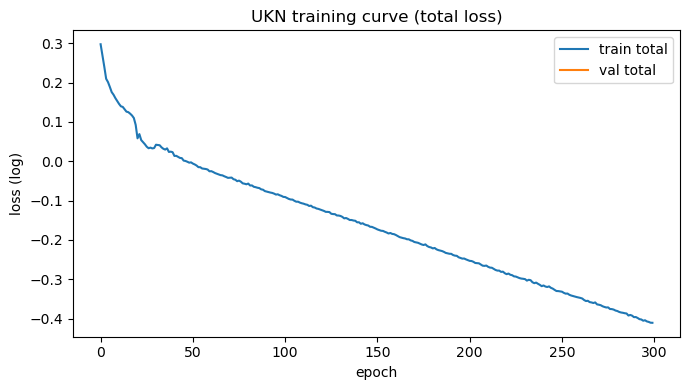

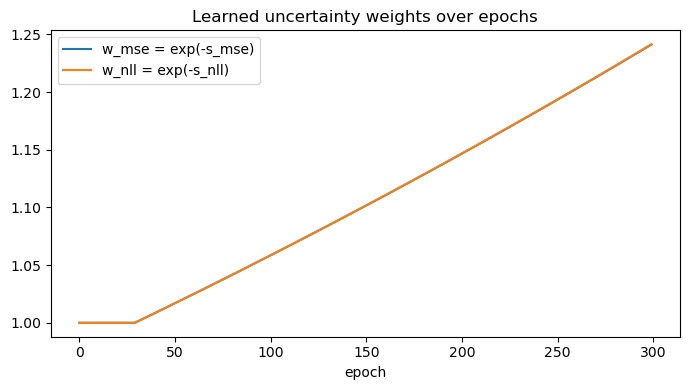

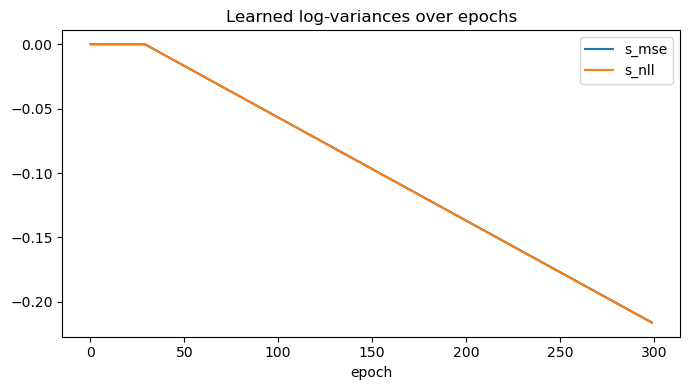

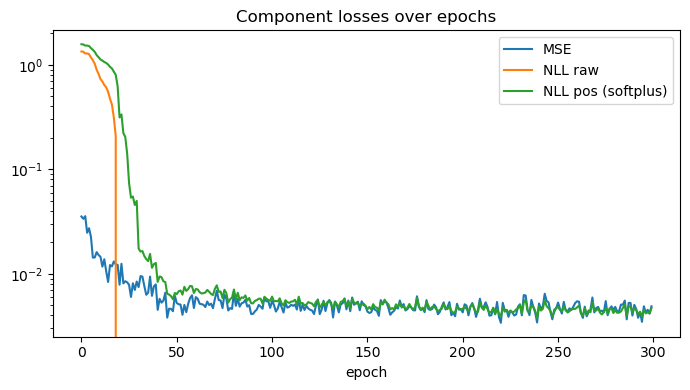

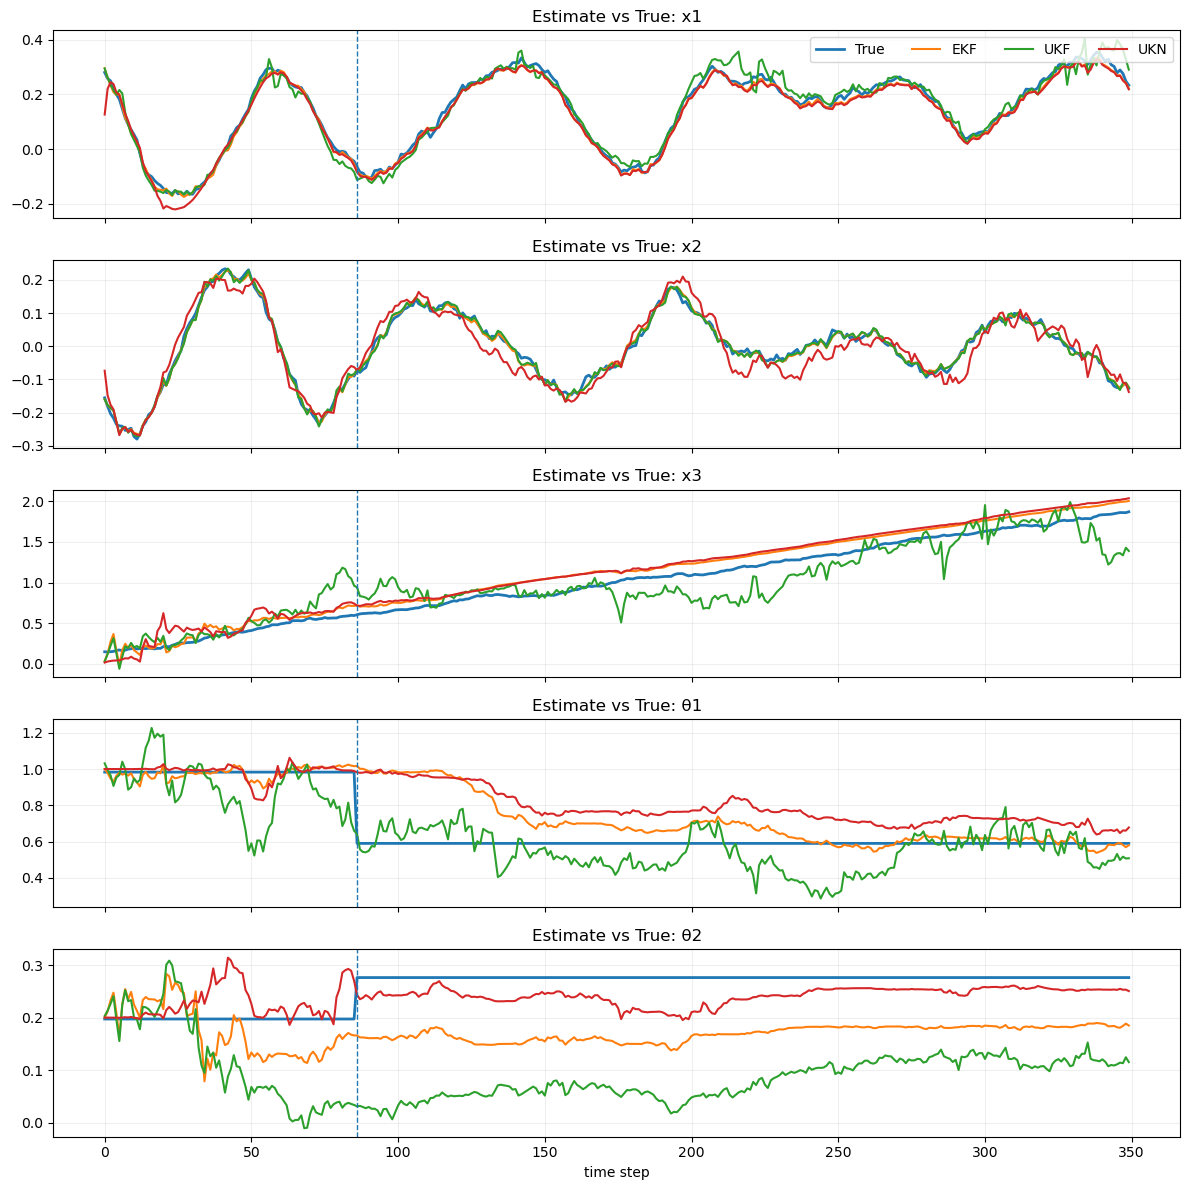

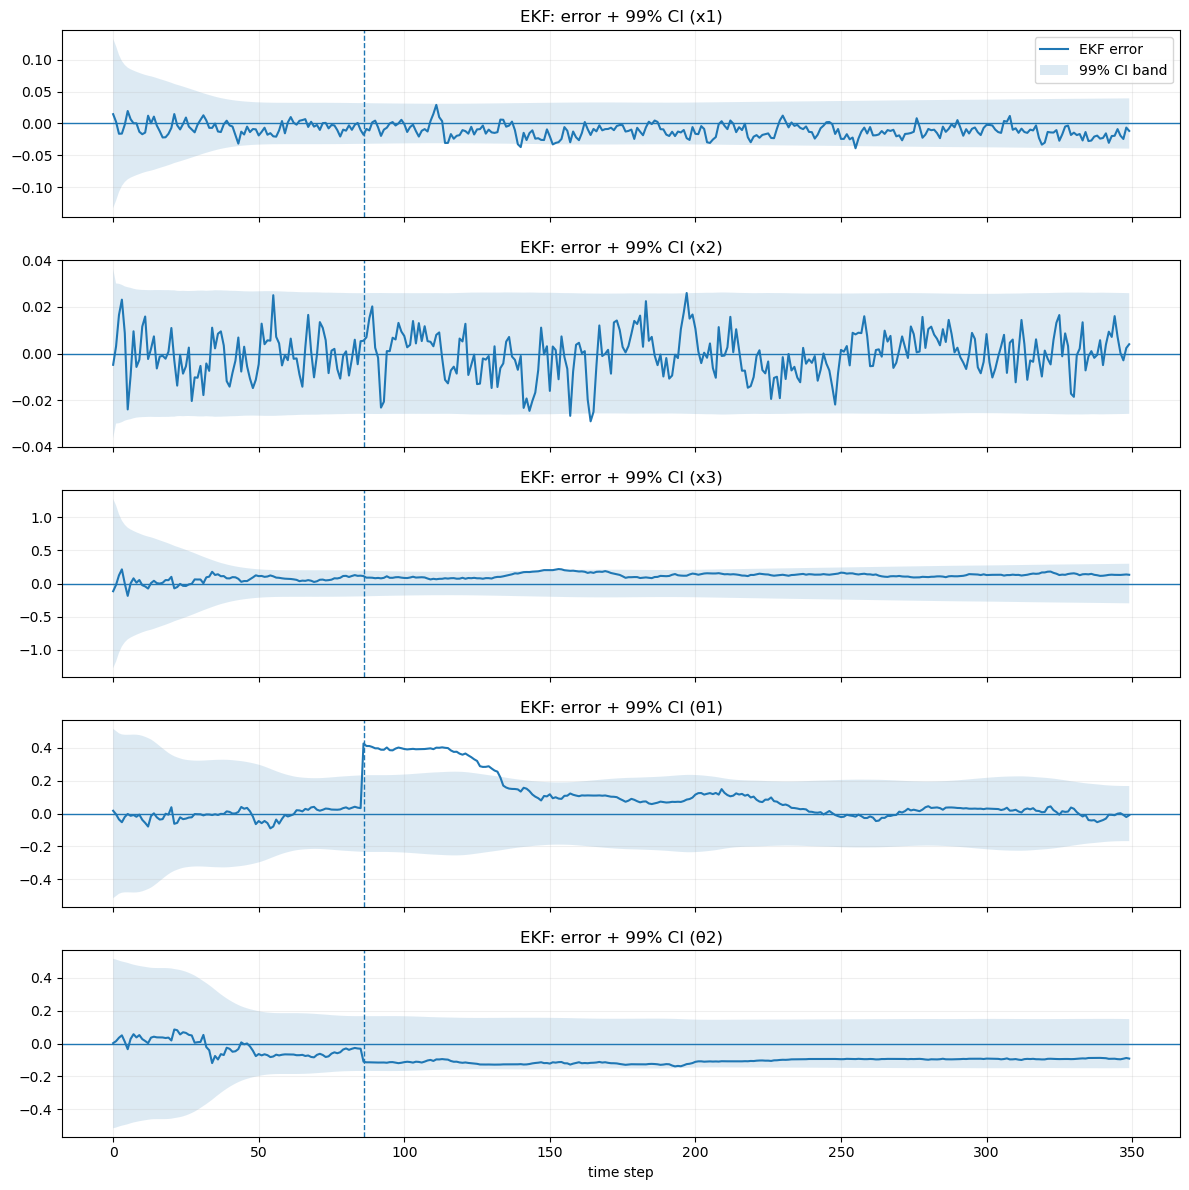

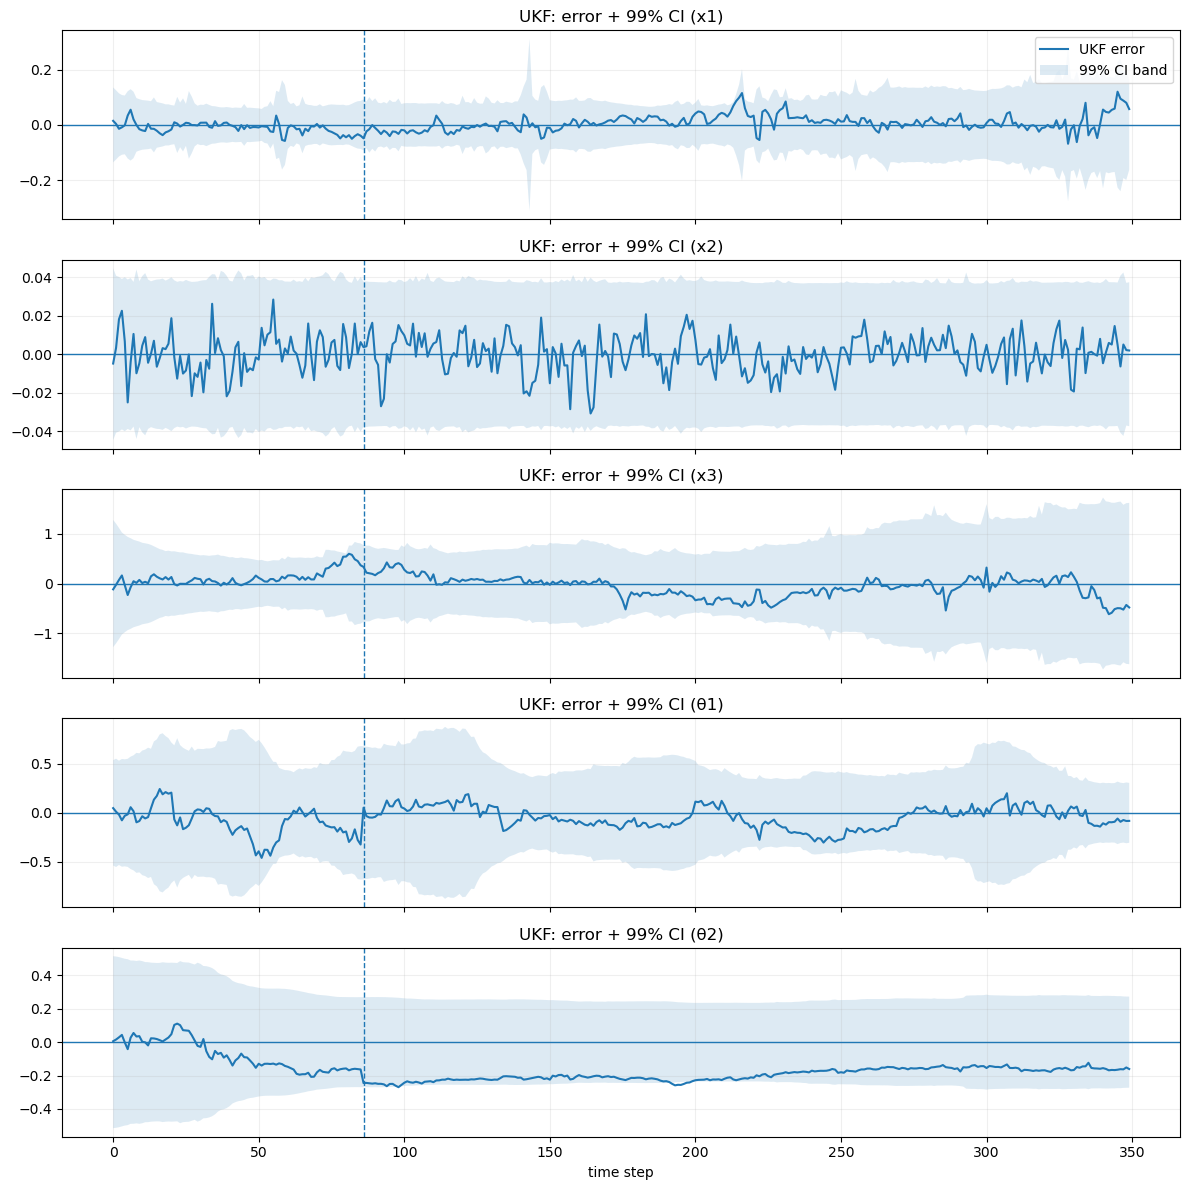

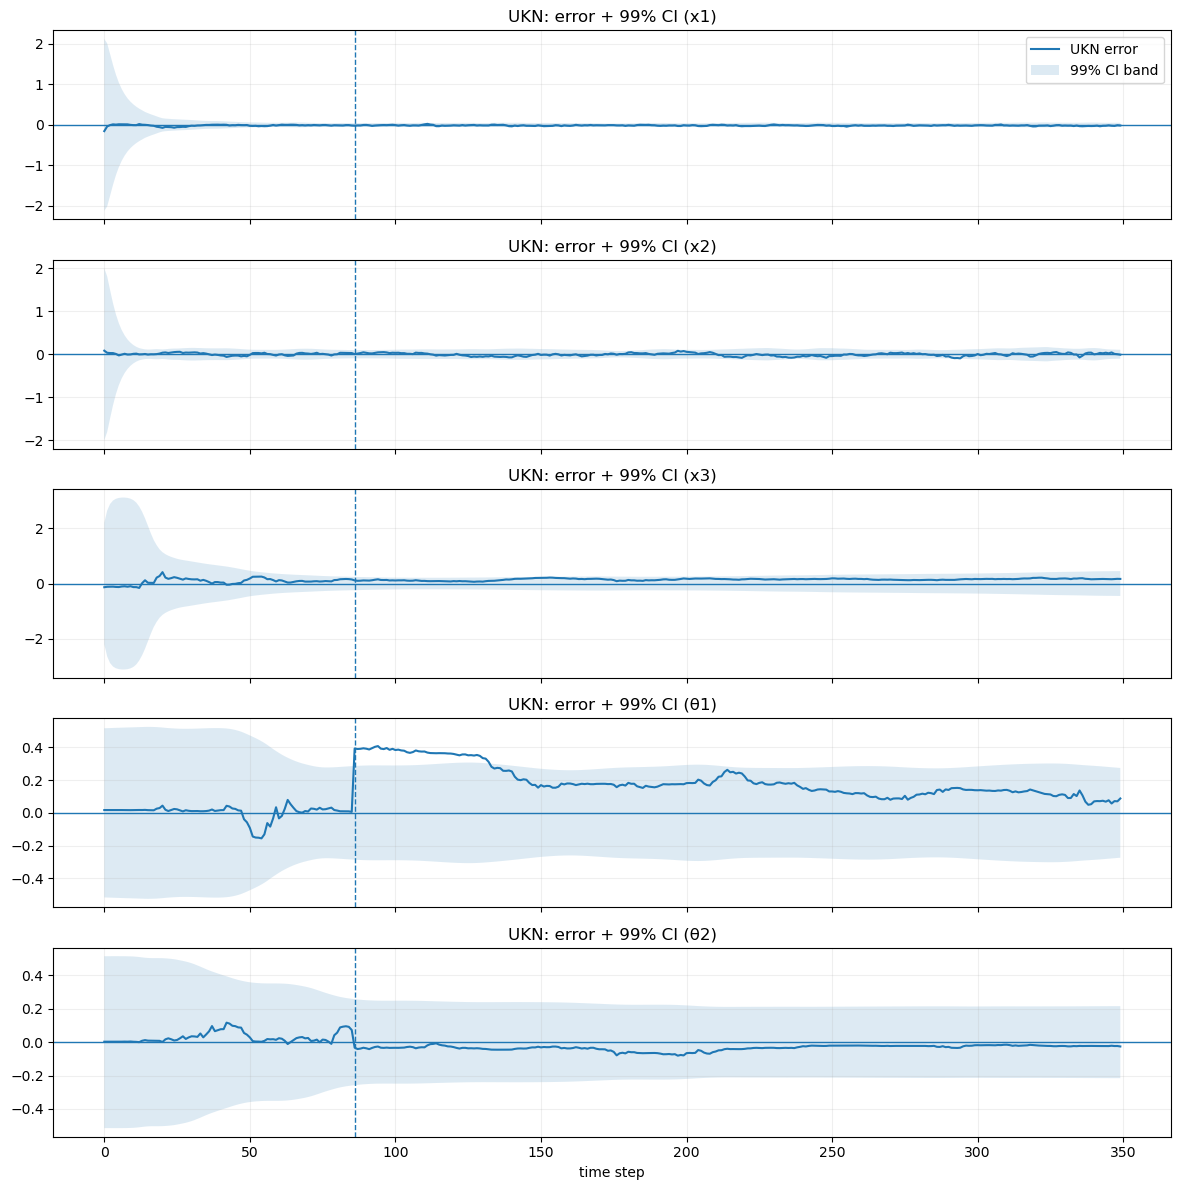

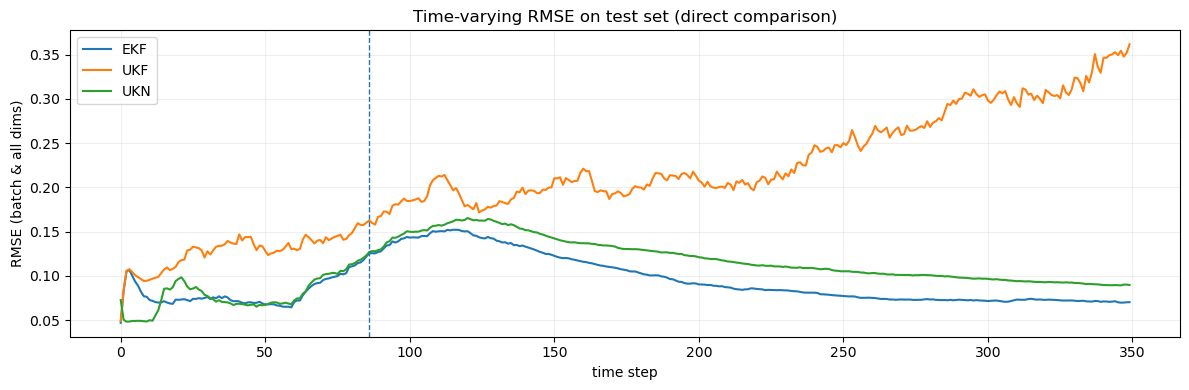

In [16]:
data = np.load(RESULTS_PATH, allow_pickle=True)

train_loss = data["train_loss"]
val_loss = data["val_loss"]
mse_hist = data["mse"]

# NLL tracking (raw vs stabilized non-negative surrogate)
nll_raw_hist = data["nll_raw"] if "nll_raw" in data.files else (data["nll"] if "nll" in data.files else None)
nll_pos_hist = data["nll_pos"] if "nll_pos" in data.files else nll_raw_hist

# learned uncertainty weights
w_mse = data["w_mse"] if "w_mse" in data.files else None
w_nll = data["w_nll"] if "w_nll" in data.files else None
s_mse = data["s_mse"] if "s_mse" in data.files else None
s_nll = data["s_nll"] if "s_nll" in data.files else None

z_true = data["z_true"]
z_ekf  = data["z_ekf"]
z_ukf  = data["z_ukf"]
z_ukn  = data["z_ukn"]

ci_ekf = data["ci_ekf"]
ci_ukf = data["ci_ukf"]
ci_ukn = data["ci_ukn"]

rmse_t_ekf = data["rmse_t_ekf"]
rmse_t_ukf = data["rmse_t_ukf"]
rmse_t_ukn = data["rmse_t_ukn"]

jump_t = data["jump_t"]
# Rt_diag = data["Rt_diag"]
# duR = data["duR"]
nis = data["nis"]

seq_id = 0
t = np.arange(CFG.T)
tj = int(jump_t[seq_id])

state_names = ["x1", "x2", "x3"]
param_names = ["θ1", "θ2"]
all_names = state_names + param_names

# (1) training curve
plt.figure(figsize=(7,4))
plt.plot(train_loss, label="train total")
plt.plot(val_loss, label="val total")
# plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss (log)")
plt.title("UKN training curve (total loss)")
plt.legend()
plt.tight_layout()
plt.show()

# learned weights & log-variances
if w_mse is not None and w_nll is not None:
    plt.figure(figsize=(7,4))
    plt.plot(w_mse, label="w_mse = exp(-s_mse)")
    plt.plot(w_nll, label="w_nll = exp(-s_nll)")
    # plt.yscale("log")
    plt.xlabel("epoch")
    plt.title("Learned uncertainty weights over epochs")
    plt.legend()
    plt.tight_layout()
    plt.show()

if s_mse is not None and s_nll is not None:
    plt.figure(figsize=(7,4))
    plt.plot(s_mse, label="s_mse")
    plt.plot(s_nll, label="s_nll")
    plt.xlabel("epoch")
    plt.title("Learned log-variances over epochs")
    plt.legend()
    plt.tight_layout()
    plt.show()
plt.figure(figsize=(7,4))
plt.plot(mse_hist, label="MSE")
if nll_raw_hist is not None:
    plt.plot(nll_raw_hist, label="NLL raw")
if nll_pos_hist is not None:
    plt.plot(nll_pos_hist, label="NLL pos (softplus)")
plt.yscale("log")
plt.xlabel("epoch")
plt.title("Component losses over epochs")
plt.legend()
plt.tight_layout()
plt.show()

# (2) estimate vs true
zT = z_true[seq_id]
zE = z_ekf[seq_id]
zU = z_ukf[seq_id]
zN = z_ukn[seq_id]

fig, axes = plt.subplots(5, 1, figsize=(12, 12), sharex=True)
for i in range(5):
    axes[i].plot(t, zT[:, i], label="True", linewidth=2.0)
    axes[i].plot(t, zE[:, i], label="EKF")
    axes[i].plot(t, zU[:, i], label="UKF")
    axes[i].plot(t, zN[:, i], label="UKN")
    axes[i].set_title(f"Estimate vs True: {all_names[i]}")
    axes[i].axvline(tj, linestyle="--", linewidth=1.0)
    axes[i].grid(True, alpha=0.2)
axes[-1].set_xlabel("time step")
axes[0].legend(loc="upper right", ncol=4)
plt.tight_layout()
plt.show()

def plot_method_errors_with_ci(method_name, err, ci, titles, t, jump_step):
    fig, axes = plt.subplots(5, 1, figsize=(12, 12), sharex=True)
    for i in range(5):
        axes[i].plot(t, err[:, i], label=f"{method_name} error")
        axes[i].fill_between(t, -ci[:, i], ci[:, i], alpha=0.15, label="99% CI band")
        axes[i].axhline(0.0, linewidth=1.0)
        axes[i].axvline(jump_step, linestyle="--", linewidth=1.0)
        axes[i].set_title(f"{method_name}: error + 99% CI ({titles[i]})")
        axes[i].grid(True, alpha=0.2)
    axes[-1].set_xlabel("time step")
    axes[0].legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# (3) errors + CI per method
plot_method_errors_with_ci("EKF", zE - zT, ci_ekf[seq_id], all_names, t, tj)
plot_method_errors_with_ci("UKF", zU - zT, ci_ukf[seq_id], all_names, t, tj)
plot_method_errors_with_ci("UKN", zN - zT, ci_ukn[seq_id], all_names, t, tj)

# (4) RMSE direct comparison
plt.figure(figsize=(12,4))
plt.plot(t, rmse_t_ekf, label="EKF")
plt.plot(t, rmse_t_ukf, label="UKF")
plt.plot(t, rmse_t_ukn, label="UKN")
plt.axvline(tj, linestyle="--", linewidth=1.0)
plt.xlabel("time step")
plt.ylabel("RMSE (batch & all dims)")
plt.title("Time-varying RMSE on test set (direct comparison)")
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# # UKN Rt diagnostics
# fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
# ax[0].plot(t, Rt_diag[seq_id,:,0], label="Rt_diag[0]")
# ax[0].plot(t, Rt_diag[seq_id,:,1], label="Rt_diag[1]")
# ax[0].axvline(tj, linestyle="--", linewidth=1.0)
# ax[0].set_title("UKN: Adaptive measurement noise (Rt_diag)")
# ax[0].legend()
# ax[0].grid(True, alpha=0.2)

# ax[1].plot(t, duR[seq_id,:,0], label="ΔuR[0]")
# ax[1].plot(t, duR[seq_id,:,1], label="ΔuR[1]")
# ax[1].axvline(tj, linestyle="--", linewidth=1.0)
# ax[1].set_title("UKN: GRU output driving R adaptation (duR)")
# ax[1].legend()
# ax[1].grid(True, alpha=0.2)

# ax[2].plot(t, nis[seq_id], label="NIS")
# ax[2].axhline(CFG.nis_tau, linestyle="--", label="tau (chi2 99%)")
# ax[2].axvline(tj, linestyle="--", linewidth=1.0)
# ax[2].set_title("UKN: Normalized Innovation Squared (NIS)")
# ax[2].legend()
# ax[2].grid(True, alpha=0.2)

# ax[2].set_xlabel("time step")
# plt.tight_layout()
# plt.show()